# Labelfree NN on the change image

Note to self: this notebook is incomplete

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

## Data

In [3]:
image_train = np.load('data/processed/image_train.npy').astype(np.float32) / 255
change_train = np.load('data/processed/change_train.npy').astype(np.float32) / 255
label_train = np.load('data/processed/label_train.npy').astype(np.float32)

image_test = np.load('data/processed/image_test.npy').astype(np.float32) / 255
change_test = np.load('data/processed/change_test.npy').astype(np.float32) / 255
label_test = np.load('data/processed/label_test.npy').astype(np.float32)

In [4]:
print(image_train.shape, change_train.shape, label_train.shape)
print(image_test.shape, change_test.shape, label_test.shape)

(520, 3, 280, 600) (520, 1, 280, 600) (520, 2)
(80, 3, 280, 600) (80, 1, 280, 600) (80, 2)


In [5]:
class TrebuchetDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TrebuchetDataset, self).__init__()
        self.X = X # Should have shape (ysize, xsize, channels, frames)
        self.y = y # Should have shape (frames,)
        assert len(X) == len(y)
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return (self.X[idx, ...], self.y[idx, ...])

In [6]:
train_dataset = TrebuchetDataset(change_train, label_train)
test_dataset = TrebuchetDataset(change_test, label_test)

In [7]:
# Must have batch size 20
train_dataloader = DataLoader(train_dataset, batch_size=20)
test_dataloader = DataLoader(test_dataset, batch_size=20)

In [8]:
# Check I/O size
iter_traindataloader = iter(train_dataloader)
features, label = next(iter_traindataloader)
features.shape, label.shape
nextfeatures, nextlabel = next(iter_traindataloader)

In [9]:
nextlabel[:, 1]

tensor([0.3625, 0.3409, 0.3246, 0.3136, 0.3079, 0.3074, 0.3120, 0.3217, 0.3365,
        0.3563, 0.3811, 0.4108, 0.4455, 0.4850, 0.5294, 0.5787, 0.6327, 0.6915,
        0.7551, 0.8234])

## Labelfree loss

In [10]:
def precompute_terms(N: int = 10, delta_t: float = 0.1, g: float = -9.8):
    # velocity and displacement terms mat
    vd_mat = np.stack([
        [i * delta_t for i in range(1, N+1)],
        [1] * N
    ], axis=1)

    accel_mat = np.array([g * (i * delta_t) ** 2 for i in range(1, N+1)])
    accel_mat = np.expand_dims(accel_mat, axis=1)

    F_mat = np.linalg.inv(vd_mat.transpose() @ vd_mat)
    F_mat = vd_mat @ F_mat @ vd_mat.transpose()

    return F_mat, accel_mat

In [11]:
def parabola_loss(preds: np.ndarray, F_mat, accel_mat):
    # preds should have shape (N, 1)
    parabola = accel_mat + F_mat @ (preds - accel_mat)
    return np.sum(np.abs(parabola - preds))

In Pytorch:

In [12]:
def parabola_loss_torch(preds: torch.Tensor, F_mat, accel_mat):
    # preds should have shape (N, 1)
    if not isinstance(accel_mat, torch.Tensor):
        accel_mat = torch.Tensor(accel_mat, device=preds.device)
        
    if not isinstance(F_mat, torch.Tensor):
        F_mat = torch.Tensor(F_mat, device=preds.device)
        
    parabola = accel_mat + F_mat @ (preds - accel_mat)
    return torch.sum(torch.abs(parabola - preds))

## Model

Same model as before:

In [13]:
class Net(nn.Module):
    """
    3 x (Conv2d-> MaxPool2d), then flattened and passed to 3 x Linear
    """
    def __init__(self):
        super(Net, self).__init__()
        layers = [
            # Input X expected to have shape (20, 1, 280, 600)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)), 
            # At this point, X shape is (20, 64, 15, 35)
            
            # nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(3, 3), stride=(1, 1)), # add this one? should trim num weights further
            
            # Flattened shape is (20, 64*15*35) = (20, 33600)
            nn.Flatten(),
            nn.Linear(in_features=33600, out_features=64),
            nn.SELU(),
            nn.Linear(in_features=64, out_features=8),
            nn.SELU(),
            nn.Linear(in_features=8, out_features=2),
            nn.Sigmoid() # Hard cap to 0 - 1 range
        ]

        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [14]:
net = Net()
net.train();

In [54]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [46]:
# Verify net I/O size
test_output = net(torch.randn(20, 1, 280, 600))

In [47]:
test_output.shape

torch.Size([20, 2])

In [48]:
epochs = 30

In [68]:
F_mat, accel_mat = precompute_terms(
    N=20, # batch size
    # delta_t=0.0333333, # seconds between frames,
    delta_t=0.01, # what if delta_t doesn't matter?
    g=9.8/4# upwards because of the coordinate frame
)

In [69]:
# Sanity check loss before training
with torch.no_grad():
    print(parabola_loss_torch(test_output[:, 1], F_mat, accel_mat))

tensor(2.5088)


In [70]:
test_output[:, 1]

tensor([0.5005, 0.5012, 0.5001, 0.5008, 0.5002, 0.4990, 0.4980, 0.5004, 0.5024,
        0.5023, 0.5014, 0.4996, 0.5015, 0.4988, 0.5008, 0.5017, 0.4999, 0.5015,
        0.5025, 0.5012], grad_fn=<SelectBackward0>)

In [71]:
fitted_test_output_parabola = accel_mat + F_mat @ (np.expand_dims(test_output[:, 1].detach().numpy(), axis=-1) - accel_mat)

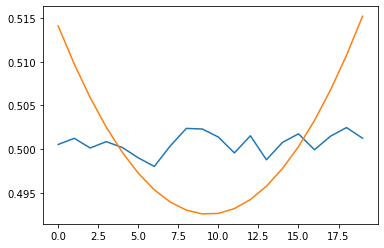

In [72]:
plt.plot(test_output[:, 1].detach().numpy())
plt.plot(fitted_test_output_parabola)

In [73]:
print(parabola_loss_torch(torch.randn(20, 1), F_mat, accel_mat))

tensor(14.1671)


In [74]:
for epoch in range(epochs):
    running_loss = 0
    
    pbar = tqdm(
        enumerate(train_dataloader), ascii=True, total=len(train_dataloader),
        bar_format='{l_bar}{bar:20}{r_bar}{bar:-10b}'
    )
    
    for count, (features, labels) in pbar:
        optimizer.zero_grad()
        output = net(features)
        
        # print(output) # there are changes, but very small!
        xpred, ypred = output[:, 0], output[:, 1]
        
        loss = parabola_loss_torch(ypred, F_mat, accel_mat) # + criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        pbar.set_description("loss: %.3f" % loss.item())

    # print(f'{epoch+1} loss: {running_loss/count:.3f}')

loss: 2.509:  81%|################1   | 21/26 [00:11<00:02,  1.81it/s]                                                  


KeyboardInterrupt: 

In [24]:
change_train_ten = torch.FloatTensor(change_train)
change_test_ten = torch.FloatTensor(change_test)

In [25]:
net.eval();

In [26]:
label_train_hat_list = []
label_test_hat_list = []

with torch.no_grad():
    for features, label in train_dataloader:
        label_train_hat = net(features)
        label_train_hat_list.append(label_train_hat)

    for features, label in test_dataloader:
        label_test_hat = net(features)
        label_test_hat_list.append(label_test_hat)

In [27]:
label_train_hat = torch.cat(label_train_hat_list, dim=0)
label_test_hat = torch.cat(label_test_hat_list, dim=0)

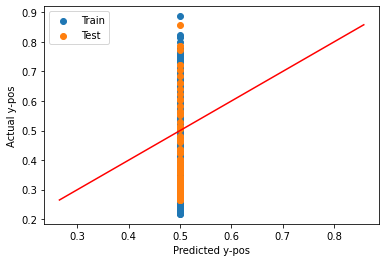

In [28]:
plt.ylabel('Actual y-pos')
plt.xlabel('Predicted y-pos')
plt.scatter(label_train_hat[:, 1], label_train[:, 1], label='Train', c='C0')
plt.scatter(label_test_hat[:, 1], label_test[:, 1], label='Test', c='C1')

# Plot y=x red line
plt.plot(
    [label_test[:, 1].min(), label_test[:, 1].max()], 
    [label_test[:, 1].min(), label_test[:, 1].max()], 
    c='red'
)
plt.legend()
plt.show()

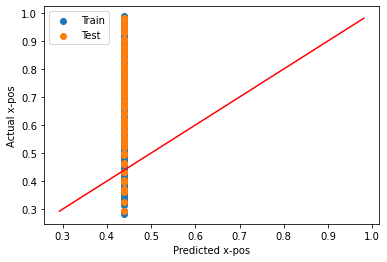

In [29]:
plt.ylabel('Actual x-pos')
plt.xlabel('Predicted x-pos')
plt.scatter(label_train_hat[:, 0], label_train[:, 0], label='Train', c='C0')
plt.scatter(label_test_hat[:, 0], label_test[:, 0], label='Test', c='C1')

# Plot y=x red line
plt.plot(
    [label_test[:, 0].min(), label_test[:, 0].max()], 
    [label_test[:, 0].min(), label_test[:, 0].max()], 
    c='red'
)
plt.legend()
plt.show()

In [30]:
# torch.save(net, "output/sl-labelfree-change.pt")